In [ ]:
## RAM is getting full while loading the 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import time
import tqdm
import os

%matplotlib notebook

In [2]:
# Device Configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Hyper-parameters 
num_epochs = 300
batch_size = 32
learning_rate = 0.001

In [6]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, wavelet = 'db1', level = 3):
        # Load your data from CSV file
        self.data = pd.read_csv(csv_path)
        self.length = len(self.data)
        self.wavelet = wavelet
        self.level = level

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # Load and preprocess the data at the given index
        sample = self.data.iloc[index]
        
        # Extract features and labels
#         coeffs = pywt.wavedec(sample.iloc[0:4095].values, self.wavelet, level=self.level)
        widths = np.arange(1,len(sample))
        cwtmatr = signal.cwt(sample, signal.ricker, widths)
        
        features = torch.tensor(np.reshape(cwtmatr, (1, cwtmatr.shape[0], cwtmatr.shape[1])), dtype=torch.float32)  # Adjust based on your column names
        label = torch.tensor(np.asarray([sample['y0'], sample['y1']*100]), dtype=torch.float32)

        return features, label

#### Reading Data

In [7]:
dataset = CustomDataset('./data/merged_data.csv')
train_data, val_data = train_test_split(dataset, test_size=0.2)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [12]:
dataset = None
train_loader = None
val_loader = None

In [ ]:
for batch_idx, (features, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1} - Features: {features.shape}, Labels: {labels.shape}")
    print("First few elements of features:")
    print(features[:5])
    print("First few elements of labels:")
    print(labels)

    if batch_idx == 0:
        break

In [20]:
# # # # To determine the input size of fully connected layer
dataiter = iter(train_loader)
images, labels = next(dataiter)

conv1 = nn.Conv2d(1, 32, 3)
pool1 = nn.MaxPool2d(5)
conv2 = nn.Conv2d(32, 64, kernel_size=10)
pool2 = nn.MaxPool2d(5)
conv3 = nn.Conv1d(64,128,kernel_size=16)
print(images.shape)
y = conv1(images)
print(y.shape)
y = pool1(y)
print(y.shape)
y = conv2(y)
print(y.shape)
y = pool2(y)
print(y.shape)
y = conv3(y)
print(y.shape)

# x = F.relu(conv1(images))
# x = pool1(x)

# x = F.relu(conv2(x))
# x = pool2(x)

# x = F.relu(conv3(x))
# print(x.shape)

torch.Size([32, 1, 4096])
torch.Size([32, 32, 4094])
torch.Size([32, 32, 409])
torch.Size([32, 64, 400])
torch.Size([32, 64, 40])
torch.Size([32, 128, 25])


#### Model

In [21]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 32, 3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(10)
        
        self.conv2 = nn.Conv1d(32,64,10)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(10)
        
        self.conv3 = nn.Conv1d(64,128,16)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc1 = nn.Linear(128*25, 512)  # Adjust input size based on your data
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)  # 2 output values for regression

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [22]:
# Instantiate the model
model = RegressionCNN().to(device)

# Print the model architecture
print(model)

RegressionCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(10,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(16,), stride=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


In [23]:
model = RegressionCNN().to(device)

In [24]:
# Loss Function
#-----------------------------------------------------
criterion = nn.MSELoss()


# Optimizer
#-----------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Scheduler
#-----------------------------------------------------
# scheduler = ExponentialLR(optimizer, gamma = 0.1)
# scheduler = StepLR(optimizer, step_size = 4, gamma = 0.5)

In [25]:
# Initialize variable to track loss and accuracies for each epochs
y_loss = {} 
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []
x_epoch = []

n_total_steps = len(train_loader)
dataset_sizes = {'train': len(train_loader), 'val': len(val_loader)}

num_epochs = 1000

for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    total_loss = 0.0

    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.to(device))

        # Compute the loss
        loss = criterion(outputs, targets.to(device))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average training loss
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs.to(device))
            val_loss += criterion(val_outputs, val_targets.to(device)).item()

    # Calculate average validation loss
    average_val_loss = val_loss / len(val_loader)
    
    y_loss['train'].append(average_loss)
    y_loss['val'].append(average_val_loss)

#     print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}')


with torch.no_grad():
    for val_inputs, val_targets in val_loader:
        val_outputs = model(val_inputs.to(device))
        print(val_outputs)
        print(val_targets.to(device))
        break

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 27.00it/s]

tensor([[ 879.4966,    6.9043],
        [ 978.6503,    9.6676],
        [ 978.2584,    9.5821],
        [ 881.6062,    7.2667],
        [ 948.6732,    8.8310],
        [ 857.0788,    6.6292],
        [ 980.5995,    9.6566],
        [1010.2243,    8.4407],
        [1016.7921,    9.3606],
        [ 998.5944,    9.5519],
        [ 973.6104,    9.2807],
        [1003.9819,    9.4906],
        [ 989.8674,    9.5697],
        [ 987.0743,    9.7981],
        [ 903.8033,    7.5990],
        [ 955.8387,    8.8383],
        [ 913.3873,    7.8254],
        [1001.5895,    9.3365],
        [ 917.9446,    7.7310],
        [ 859.9528,    6.6079],
        [ 818.9124,    6.5428],
        [ 873.8605,    6.7075],
        [ 878.9866,    6.9893],
        [ 995.0230,    9.6707]], device='cuda:0')
tensor([[ 909.0000,    5.2000],
        [1003.0000,   10.0000],
        [1006.0000,   10.0000],
        [ 907.0000,    4.9000],
        [1006.0000,   10.1000],
        [ 877.0000,    6.4000],
        [1015.0000,   

<IPython.core.display.Javascript object>


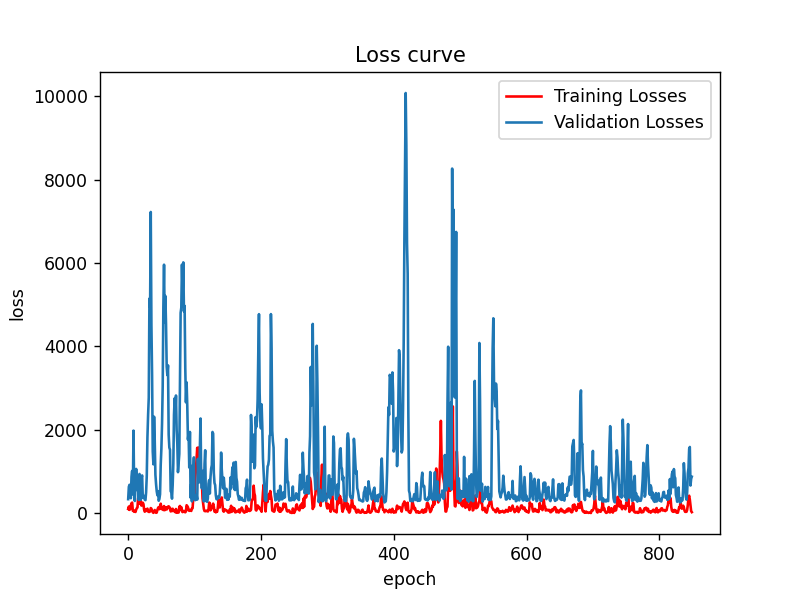

In [26]:
# Plot Loss curve
plt.plot(y_loss['train'][150:], "-r", label = "Training Losses")
plt.plot(y_loss['val'][150:], label = "Validation Losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss curve")
plt.legend()
plt.show()
# plt.savefig("./img/b"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs)+"_Loss_sgd.png")

In [92]:


# # start
# start = time.time()
# for epoch in tqdm.tqdm(range(num_epochs)):
#     for phase in ['train', 'val']:        
#         running_loss = 0.0
#         running_corrects = 0.0
#         count = 0
#         total = 0
#         if(phase == 'train'):
#             for images, labels in train_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
        
#                 # Forward pass
#                 outputs = model(images)
#                 _, preds = torch.max(outputs.data, 1)
#                 loss = criterion(outputs, labels)

#                 # Backward and optimize
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 # the class with the highest energy is what we choose as prediction        
#                 running_loss += loss.item()              
#                 total += labels.size(0)
#                 running_corrects += (preds == labels).sum().item()
        
#             epoch_loss = running_loss / total
#             epoch_acc = running_corrects / total
# #             if (i+1) % 20 == 0:
# #             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             y_loss[phase].append(epoch_loss)
#             y_err[phase].append(1.0 - epoch_acc)
# #             scheduler.step()

            
#         elif(phase == 'val'):
#             for i, (images, labels) in enumerate(val_loader):
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Forward pass
#                 outputs = model(images)
#                 _, preds = torch.max(outputs.data, 1)
#                 loss = criterion(outputs, labels)
                
#                 # the class with the highest energy is what we choose as prediction
#                 running_loss += loss.item()              
#                 total += labels.size(0)
#                 running_corrects += (preds == labels).sum().item()               
                
#             epoch_loss = running_loss / total
#             epoch_acc = running_corrects / total
# #             if (i+1) % 200 == 0:
# #             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             y_loss[phase].append(epoch_loss)
#             y_err[phase].append(1.0 - epoch_acc)

#             x_epoch.append(epoch)  
            
# print(f'training time: {(time.time()-start)} sec')
# # end